<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/RadNET_64x64_FullWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data Loading

In [1]:
!pip install --upgrade segyio
import segyio
import numpy as np
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import time
# import itertools
import os
import re
import random
# from PIL import Image
from scipy import spatial, signal
import json
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display
import datetime
import tensorflow as tf

     |████████████████████████████████| 92kB 7.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Functions

In [3]:
########
# Functions for creating synthetic noise

def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1070, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)


########
# Griffin Lim implementation for estimating phase

def griffin_lim(magnitude, iterations, orig_sig, fs, nperseg, noverlap, window):
    """
    Inputs:
      magnitude: the real-value spectrogram array to be converted to signal
      iterations: number of iterations to perform Griffin Lim, suggest several hundred -> 1000
      orig_sig: the original time-domain signal prior to enhancement
            -typical GLA uses random initial signal, using original signal improves stability
      fs, nperseg, noverlap, window: parameters from original STFT


    Returns:
      GLA reconstructed time domain signal

    """
    sig_recon = orig_sig

    error = []

    while iterations > 0:
        _, _, temp_spec = signal.stft(sig_recon, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
        comp_angle = np.angle(temp_spec)
        new_spec = magnitude*np.exp(1j*comp_angle)
        prev_sig = sig_recon
        _, sig_recon = signal.istft(new_spec, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

        if iterations % 10 == 0:
            try:
                rmse = sqrt(sum((sig_recon - prev_sig)**2) / prev_sig.size)
                error.append(rmse)
            except ValueError:
                if len(sig_recon) > len(prev_sig):
                    sig_recon_tmp = sig_recon[:len(prev_sig)]
                    rmse = sqrt(sum((sig_recon_tmp - prev_sig)**2) / prev_sig.size)
                    error.append(rmse)
                if len(sig_recon) < len(prev_sig):
                    prev_sig_tmp = prev_sig[:len(sig_recon)]
                    rmse = sqrt(sum((sig_recon - prev_sig_tmp)**2) / prev_sig_tmp.size)
                    error.append(rmse)
        # print("\rCurrent error for iteration ", iterations,": ", rmse, end='', flush=True)
        
        iterations -= 1

    return sig_recon, error

## Numpy file generation

In [ ]:
#--------------------------------------------------
##################
## Variables and parameters

# Specify which dataset version is being created
# Options: 'noise', '2D_to_3D'

dataset_type = 'noise'


num_files = 5000
trace_list_2D = []  # comment out if building with multiple runs)
    
input_dimension = (64, 64)  
input_data_2D = np.zeros((num_files, input_dimension[0], input_dimension[1]))
input_data_3D = np.zeros((num_files, input_dimension[0], input_dimension[1]))
input_data_Noisy = np.zeros((num_files, input_dimension[0], input_dimension[1]))

trace_len_clip_2D_start = 1970   # Trimming 2D data to approximately match 3D
trace_len_clip_2D_end = 3040

# Zxx parameters
fs = 1 / 0.0000000375     #sample frequency
nperseg = 127        # nperseg/noverlap combo produces 64x32 assuming 1070 samples
noverlap = 92
window = signal.hann(nperseg, sym=False)

# Noise parameters
min_freq1 = 3000000   
max_freq1 = 3020000
amp_scaler1 = 200   # used to scale the noise up or down
min_freq2 = 6000000   
max_freq2 = 6100000
amp_scaler2 = 60

#--------------------------------------------------



##################
## Seismic Data filepaths
## Loading trace match dictionary

Volume3D = "/content/drive/My Drive/RadNET/GAN data/3D/PB3D_Fritz_subset.sgy"

Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
    TraceDict = json.load(TraceDictFile)



##################
## Get 2D and 3D traces randomly
## Perform STFT
## Shape and scale arrays

file_counter=0
while file_counter < num_files:
    
    # Randomly choose value from trace match dictionary
    Rand2D = random.choice(list(TraceDict.items()))
    RandTraceMatch = random.choice(list(Rand2D[1].items()))

    # Set the random choice to variables, print information
    # The dictionary captures trace numbers from TRACE_SEQUENCE_LINE,
    # which compared to the numpy array is index + 1, therefore need to 
    # subtract 1 to get the proper index value
    Rand2DLine = int(Rand2D[0])
    Rand2DTrace = int(RandTraceMatch[0])-1
    Rand3DTrace = int(RandTraceMatch[1][0])-1
    
    # check if we've already grabbed the random trace
    if (str(Rand2DLine)+str(Rand2DTrace)) in trace_list_2D:
        continue
    trace_list_2D.append(str(Rand2DLine)+str(Rand2DTrace))
    
    # Get the random 2D trace data
    Rand2DFile = "/content/drive/My Drive/RadNET/GAN data/2D/" + str(Rand2DLine) + ".sgy"
    with segyio.open(Rand2DFile, 'r') as segyfile:
        display_trace_2D = segyfile.trace[Rand2DTrace]
        display_trace_2D = display_trace_2D[trace_len_clip_2D_start:trace_len_clip_2D_end]

    # Check for dead 2D traces
    if np.amax(display_trace_2D) < -100:
        continue

    # Scale 2D data
    scaler2D = StandardScaler()    
    standardized_2D_trace = np.squeeze(scaler2D.fit_transform(display_trace_2D.reshape((len(display_trace_2D), 1))))

    # Get the random (matched) 3D trace data
    if dataset_type == '2D_to_3D':
        with segyio.open(Volume3D, 'r') as segyfile:
            display_trace_3D = segyfile.trace[Rand3DTrace]

        # Scale 3D data
        scaler3D = StandardScaler()
        standardized_3D_trace = np.squeeze(scaler3D.fit_transform(display_trace_3D.reshape((len(display_trace_3D), 1))))

    # Get the random (matched) 3D trace data
    if dataset_type == 'noise':
        samples = len(standardized_2D_trace)
        noise1 = band_limited_noise(min_freq1, max_freq1, samples = samples, samplerate=fs)
        noise2 = band_limited_noise(min_freq2, max_freq2, samples = samples, samplerate=fs)
        noisy_trace = (noise1 * amp_scaler1) + (noise2 * amp_scaler2) + standardized_2D_trace

    # Perform STFT, shape and scale data
    _, _, Zxx2D = signal.stft(standardized_2D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
    Mag_2D = np.abs(Zxx2D)
    Mag_2D = np.repeat(Mag_2D, 2, axis=1)
    Mag_2D = np.log(Mag_2D)

    try:
        _, _, Zxx3D = signal.stft(standardized_3D_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
        Mag_3D = np.abs(Zxx3D)
        Mag_3D = np.repeat(Mag_3D, 2, axis=1)
        Mag_3D = np.log(Mag_3D)
    except: 
        pass

    try:
        _, _, ZxxNoisy = signal.stft(noisy_trace, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
        Mag_Noisy = np.abs(ZxxNoisy)
        Mag_Noisy = np.repeat(Mag_Noisy, 2, axis=1)
        Mag_Noisy = np.log(Mag_Noisy)

    
    
    # Place data into holder arrays
    input_data_2D[file_counter, :, :] = Mag_2D

    try:
        input_data_3D[file_counter, :, :] = Mag_3D
    except:
        pass

    try:
        input_data_Noisy[file_counter, :, :] = Mag_Noisy
    except:
        pass
    
    file_counter+=1

## Load data Numpy files, create Dataset

In [6]:
##################
## Load numpy files
## Create Tensorflow Dataset
start = time.time()


#---------------------------
# Specify whether to load NOISY data 
# or 3D data as input

input_data_type = 'NOISY'

#---------------------------




input_data_dir_2D = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Training/2D"
input_data_dir_3D = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Training/3D"
input_data_dir_Noisy = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Training/Noisy"

numpy_filepaths_2D = []
for root, dirs, files in os.walk(input_data_dir_2D):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_2D.append(filename)

numpy_filepaths_3D = []
for root, dirs, files in os.walk(input_data_dir_3D):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_3D.append(filename)

numpy_filepaths_Noisy = []
for root, dirs, files in os.walk(input_data_dir_Noisy):
    for name in files:
        if name.endswith('.npy'):
            filename = os.path.join(root, name)
            numpy_filepaths_Noisy.append(filename)

assert len(numpy_filepaths_2D) == len(numpy_filepaths_3D), 'Check 2D and 3D filepaths'
assert len(numpy_filepaths_2D) == len(numpy_filepaths_Noisy), 'Check 2D and Noisy filepaths'

input_dimension = (64, 64)
specs_per_training_file = 5000 
total_files =  specs_per_training_file*len(numpy_filepaths_2D)

data_target_holder = np.zeros((total_files, input_dimension[0], input_dimension[1]))
data_input_holder = np.zeros((total_files, input_dimension[0], input_dimension[1]))


for N in range(len(numpy_filepaths_2D)):
    tmp_target_arr = np.load(numpy_filepaths_2D[N])

    if input_data_type == 'NOISY':
        tmp_input_arr = np.load(numpy_filepaths_Noisy[N])
    if input_data_type == '3D':
        tmp_input_arr = np.load(numpy_filepaths_3D[N])

    insertion_idx = N * specs_per_training_file

    data_target_holder[insertion_idx:insertion_idx + specs_per_training_file, :, :] = tmp_target_arr
    data_input_holder[insertion_idx:insertion_idx + specs_per_training_file, :, :] = tmp_input_arr



# Scale and shape data

minmax_target = MinMaxScaler()
minmax_input = MinMaxScaler()

data_target_holder = minmax_target.fit_transform(np.expand_dims(data_target_holder.flatten(), axis=1))
data_target_holder = np.reshape(data_target_holder, (total_files, input_dimension[0], input_dimension[1]))
data_target_holder = np.expand_dims(data_target_holder, axis=-1)

data_input_holder = minmax_input.fit_transform(np.expand_dims(data_input_holder.flatten(), axis=1))
data_input_holder = np.reshape(data_input_holder, (total_files, input_dimension[0], input_dimension[1]))
data_input_holder = np.expand_dims(data_input_holder, axis=-1)



# Create Tensor Dataset

BATCH_SIZE = 64

data_tf_target = tf.convert_to_tensor(data_target_holder, np.float32)
data_tf_input = tf.convert_to_tensor(data_input_holder, np.float32)

train_dataset_target = tf.data.Dataset.from_tensor_slices(data_tf_target)
train_dataset_target = train_dataset_target.batch(BATCH_SIZE)

train_dataset_input = tf.data.Dataset.from_tensor_slices(data_tf_input)
train_dataset_input = train_dataset_input.batch(BATCH_SIZE)

# del data_target_holder
# del data_input_holder

end = time.time()
print("Time to completion (s): ", round(end-start))

Time to completion (s):  62


# Model

## Architecture

In [7]:
# Define discriminator and generator models
# Define loss and optimizers
# Instantiate models


BATCH_SIZE = 64

OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS])
        
    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 32, 32, 64)
    downsample(128, 4), # (bs, 16, 16, 128)
    downsample(256, 4), # (bs, 8, 8, 256)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
  
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS], name='input_image')
    tar = tf.keras.layers.Input(shape=[input_dimension[0], input_dimension[1], OUTPUT_CHANNELS], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


# define loss and optimizers

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss



generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


# Instantiate the models 
generator = Generator()
discriminator = Discriminator()

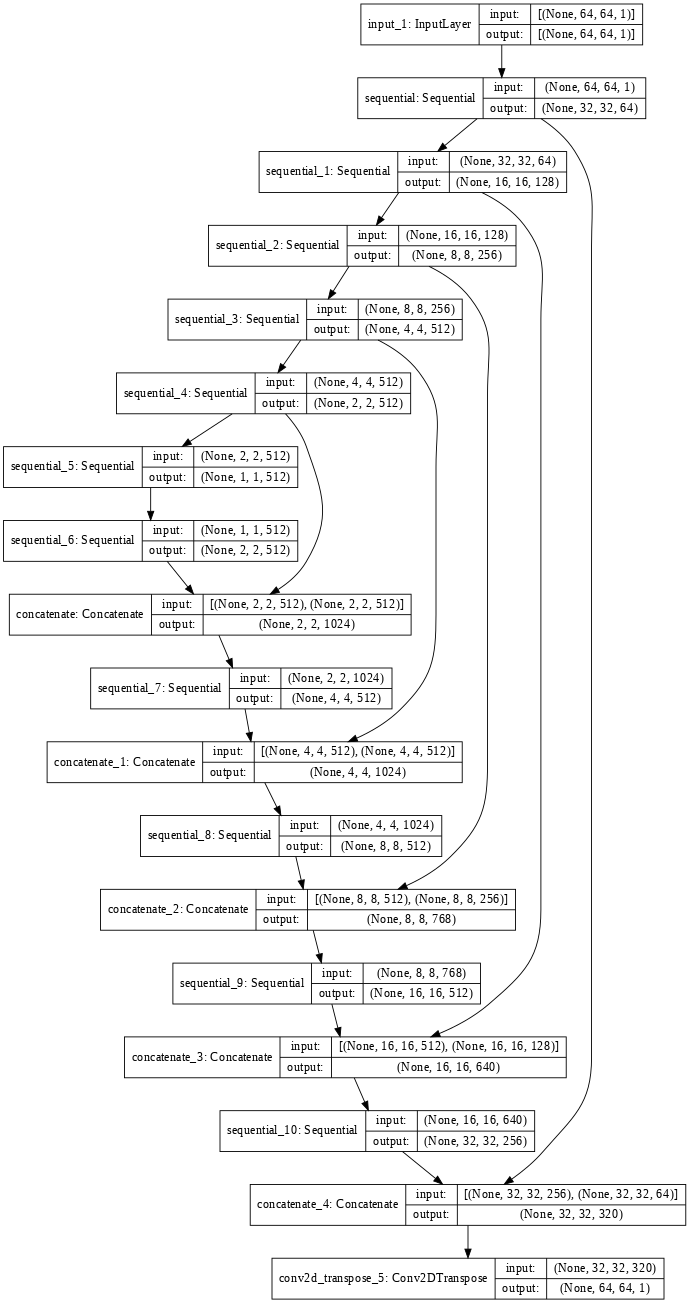

In [ ]:
## Display graphical model description

# Generator().summary()
# Discriminator().summary()

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## Define Training Steps and Checkpoints

In [8]:
# set up checkpoints and define training / fit steps

# log_dir="/content/drive/My Drive/RadNET/logs/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

training_name = 'June_Update_Noise'
checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints/' + training_name
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
def fit(train_input, train_target, epochs, chkpt_save):
    for epoch in range(epochs):
        display.clear_output(wait=True)
        try:
            print ('Time taken for epoch {} was {} sec\n'.format(epoch - 1,
                                                        time.time()-start))
        except:
            pass

        start = time.time()
        print("Epoch ", epoch, " running...")

        n=0
        # Train (separate Datasets for input and target)
        for input_image, target in tf.data.Dataset.zip((train_input, train_target)):
            train_step(input_image, target, epoch)
            if (n+1) % 100 == 0:
                print('.', end='')
            n +=1 
    
        print()

        


    # saving (checkpoint) the model every chkpt_save epochs
        if (epoch + 1) % chkpt_save == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    checkpoint.save(file_prefix = checkpoint_prefix)

# Model Training

In [9]:
# Load latest checkpoint if picking up / continuing training 
# Skip if starting from scratch

# Designate which model to load from checkpoint:
training_name = 'June_Update_Noise'
checkpoint_dir = '/content/drive/My Drive/RadNET/training_checkpoints/' + training_name

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Define how many epochs to run model
EPOCHS = 99
chkpt_save = 50

# Run the model
fit(train_dataset_input, train_dataset_target, EPOCHS, chkpt_save)

print("Training Complete!")

# Run Predictions on Test Dataset

In [11]:
##################
## Use current model to perform predictions

# Specify which dataset version is being created
# Options: 'noise', '2D_to_3D'

dataset_type = 'noise'

if dataset_type == 'noise':
    input_data_path = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Testing/Testing_Noisy_100.npy"
    input_trace_path = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Testing/Testing_Noisy_100_TRACES.npy"
elif dataset_type == '2D_to_3D':
    input_data_path = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Testing/Testing_3D_100.npy"
    input_trace_path = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Testing/Testing_3D_100_TRACES.npy"

input_data = np.load(input_data_path)
input_traces = np.load(input_trace_path)
num_predictions = input_data.shape[0]

prediction_inputs = minmax_input.transform(np.expand_dims(input_data.flatten(), axis=1))
prediction_inputs = np.reshape(prediction_inputs, (input_data.shape[0], input_dimension[0], input_dimension[1]))
prediction_inputs = np.expand_dims(prediction_inputs, axis=-1)

prediction_outputs = generator.predict(prediction_inputs)
prediction_outputs = minmax_target.inverse_transform(np.expand_dims(prediction_outputs.flatten(), axis=1))
prediction_outputs = np.reshape(prediction_outputs, (num_predictions, input_dimension[0], input_dimension[1]))


# output_data_folder = 'June_2021_Noise_v1'
# output_prediction_path = os.path.join("/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Predictions",
#                                       output_data_folder)
# np.save(output_prediction_path, prediction_outputs)

## Visualize prediction vs input and target

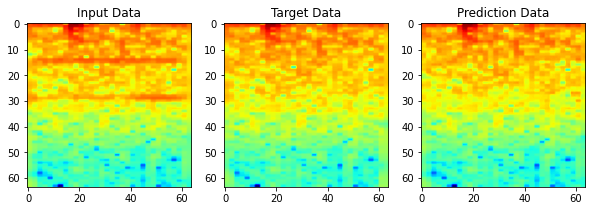

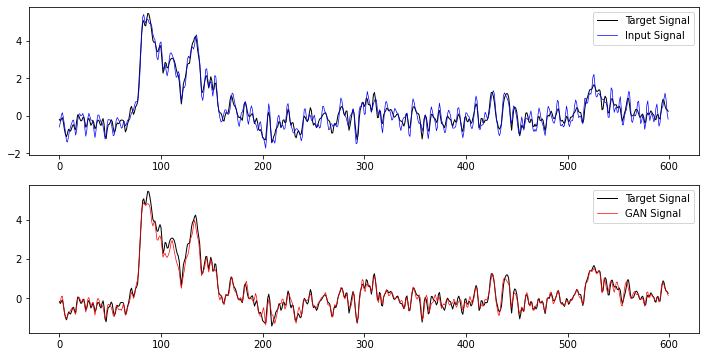

In [18]:
##################
## Load target data
target_path = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Testing/Testing_2D_100.npy"
target_data = np.load(target_path)

target_trace_path = "/content/drive/My Drive/RadNET/GAN data/Spec_Numpy_Arrays/Testing/Testing_2D_100_TRACES.npy"
target_traces = np.load(target_trace_path)


#------------------
# Choose which example index to show

plot_idx = 20  

#------------------




##################
## Plot Input - Target - Prediction Spectrograms


colormap='jet'

plot_input_data = input_data[plot_idx,:,:]
plot_target_data = target_data[plot_idx,:,:]
plot_prediction_data = prediction_outputs[plot_idx,:,:]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
ax[0].imshow(plot_input_data, cmap=colormap)
ax[0].set_title("Input Data")
ax[1].imshow(plot_target_data, cmap=colormap)
ax[1].set_title("Target Data")
ax[2].imshow(plot_prediction_data, cmap=colormap)
ax[2].set_title("Prediction Data")
plt.show()



##################
## Shape prediction back to proper size
## Use modified Griffim Lim Algorithm to recover time series signal

input_signal = input_traces[plot_idx,:]
target_signal = target_traces[plot_idx,:]

prediction_data_reduced = np.zeros((plot_prediction_data.shape[0], int(plot_prediction_data.shape[1]/2)))

for i in range(prediction_data_reduced.shape[0]):
    idx_counter = 0
    for j in range(prediction_data_reduced.shape[1]):
        prediction_data_reduced[i,j] = np.mean(plot_prediction_data[i,idx_counter:idx_counter+2])
        idx_counter += 2

prediction_data_reduced = np.exp(prediction_data_reduced)


# Zxx parameters - Use same as during data generation
fs = 1 / 0.0000000375     #sample frequency
nperseg = 127        # nperseg/noverlap combo produces 64x32 assuming 1070 samples
noverlap = 92
window = signal.hann(nperseg, sym=False)

predicted_signal, _ = griffin_lim(prediction_data_reduced, 300, input_signal, 
                                  fs, nperseg, noverlap, window)

target_color = 'black'
input_color = 'blue'
prediction_color = 'red'

plot_start_idx = 200
plot_stop_idx = 800

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=((12,6)))
ax[0].plot(target_signal[plot_start_idx:plot_stop_idx], c=target_color, linewidth=1, label='Target Signal')
ax[0].plot(input_signal[plot_start_idx:plot_stop_idx], c=input_color, linewidth=0.7, label='Input Signal')
ax[0].legend()

ax[1].plot(target_signal[plot_start_idx:plot_stop_idx], c=target_color, linewidth=1, label='Target Signal')
ax[1].plot(predicted_signal[plot_start_idx:plot_stop_idx], c=prediction_color, linewidth=0.7, label='GAN Signal')
ax[1].legend()

plt.show()